### Quantify spillovers from fire treatments

Let's calculate the effect of spillovers on our treatments. Here the treatment is the burn scar and not the low-intensity treatments

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../")

from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.plot import template_plots
from prescribed.utils import calculate_fire_pop_dens

from src.prescribed.estimate.create_distances import create_distances

In [4]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [6]:
pop_zip = list(Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif"))
pop_dict = {
    int(p.stem.split("_")[-3]): p
    for p in Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif")
}

In [8]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[
    (mtbs.Event_ID.str.contains("CA"))
    & (mtbs.Incid_Type.isin(["Wildfire", "Prescribed Fire"]))
].to_crs("3310")
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Load California boundaries
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("4326")

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Add land types
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

In [9]:
pop_dens = calculate_fire_pop_dens(
    geoms=mtbs_ca,
    pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population",
    mask=ca,
    template=template,
)

Calculating population density...: 100%|██████████| 1886/1886 [00:41<00:00, 45.48it/s]


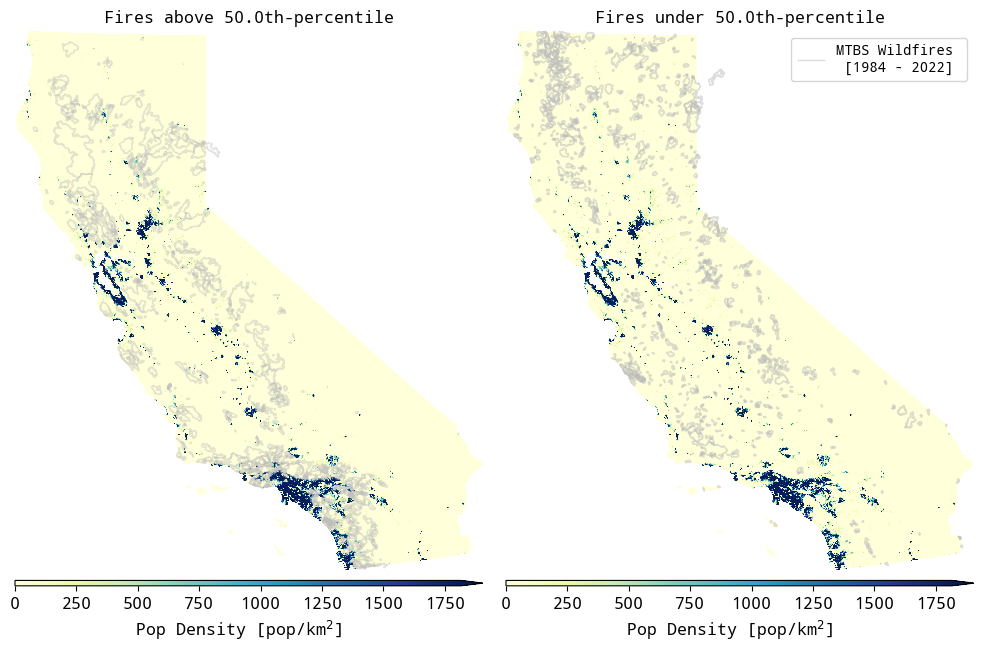

In [ ]:
############################# PREPARE DATA FOR PLOT ############################
ds = rioxarray.open_rasterio(pop_dict[2020]).squeeze()

with xr.set_options(keep_attrs=True):
    clip_box = ds.rio.clip_box(*ca.total_bounds)
    cal_pop = clip_box.rio.clip(
        ca.geometry.values, ca.crs, drop=True, invert=False
    ).rio.reproject_match(template)

    cal_pop = xr.where(cal_pop == ds.attrs["_FillValue"], np.nan, cal_pop)
################################################################################


fig, ax = plt.subplots(1, 2, figsize=(10, 12))

thresh_def = 0.50

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

cal_pop.plot(
    robust=True,
    ax=ax[0],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={"label": r"Pop Density [pop/km$^2$]", "orientation": "horizontal"},
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop >= tresh]

subset_events.geometry.boundary.plot(ax=ax[0], color="#bdbdbd", linewidth=1, alpha=0.4)

template_plots(ax[0], no_axis=True, ylab="", xlab="")

ax[0].set_title(f"Fires above {thresh_def * 100}th-percentile", fontsize=12)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Low density
cal_pop.plot(
    robust=True,
    ax=ax[1],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={"label": r"Pop Density [pop/km$^2$]", "orientation": "horizontal"},
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop <= tresh]

subset_events.geometry.boundary.plot(
    ax=ax[1],
    color="#bdbdbd",
    linewidth=1,
    alpha=0.5,
    label="MTBS Wildfires \n [1984 - 2022]",
)
ax[1].legend(loc="upper right", fontsize=10)

template_plots(ax[1], no_axis=True, ylab="", xlab="")

ax[1].set_title(f"Fires under {thresh_def * 100}th-percentile", fontsize=12)

# Save plot
plt.tight_layout()
#plt.savefig("../figs/pop_density_fires.png", dpi=300)

In [10]:
test_dist = create_distances(mtbs_shapefile=mtbs_ca, 
                             template=template, 
                             buffer=10_000, # population buffer
                             pop_threshold=0.5,
                             buffer_treatment=10_000, 
                             pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population", mask=ca)

test_dist = test_dist.merge(land_type.drop(columns=["lat", "lon"]), on="grid_id")

Calculating population density...: 100%|██████████| 1886/1886 [00:42<00:00, 44.07it/s]


<Axes: xlabel='lon', ylabel='lat'>

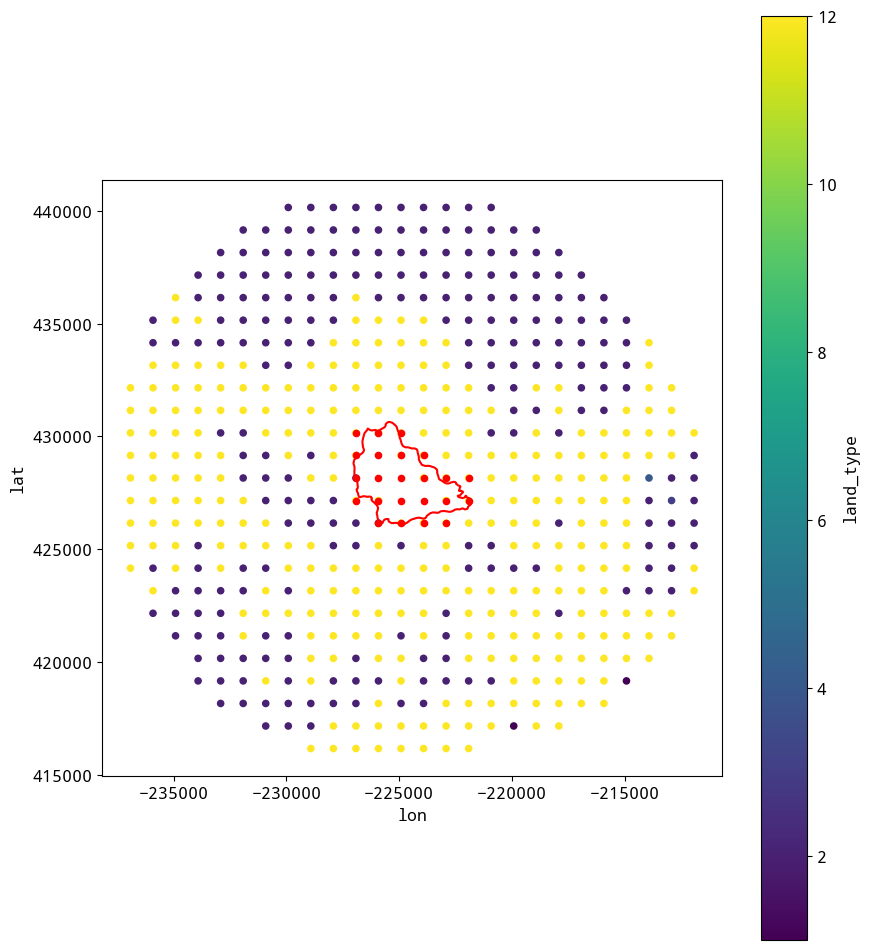

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
test_dist[(test_dist.donut == "CA4184212270320070710")].plot.scatter(x='lon', y='lat', c="land_type", ax=ax)
test_dist[(test_dist.wildfire == "CA4184212270320070710")].plot.scatter(x='lon', y='lat', color="red", ax=ax)
mtbs_ca[mtbs_ca.Event_ID == "CA4184212270320070710"].boundary.plot(ax=ax, color='red') 

<Axes: xlabel='lon', ylabel='lat'>

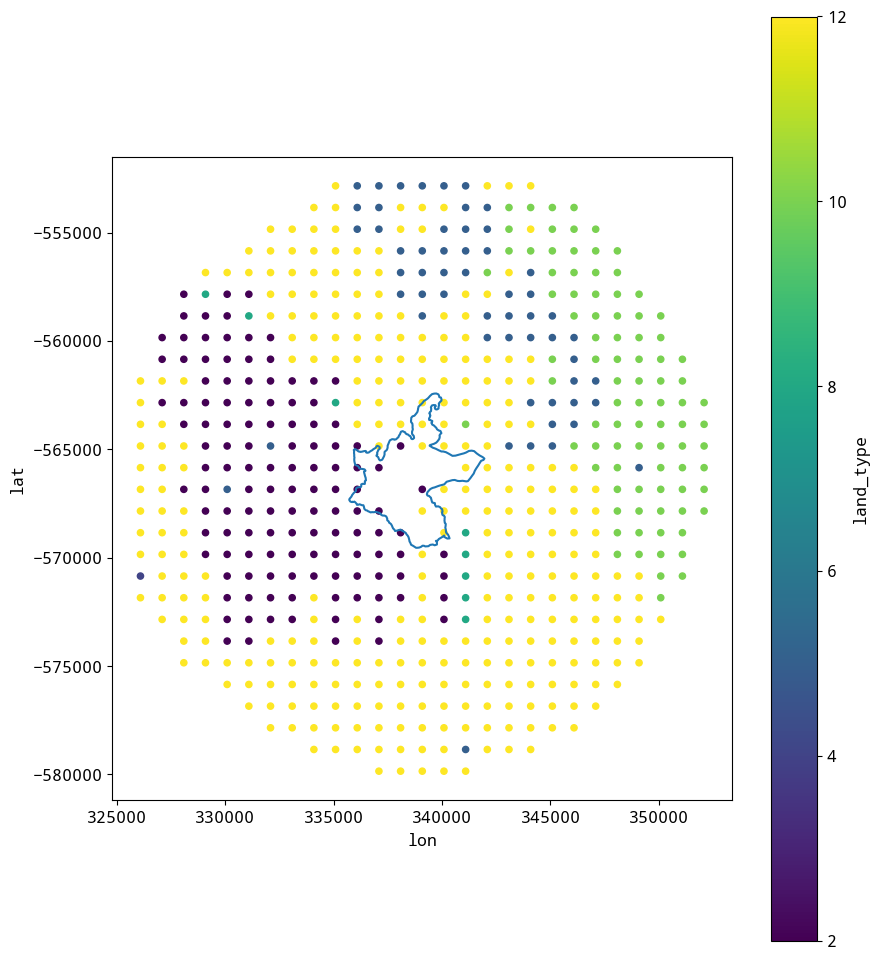

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
test_dist[(test_dist.donut == "CA3285711638619890709")].plot.scatter(x="lon", y="lat", ax=ax, c="land_type")
mtbs_ca[mtbs_ca.Event_ID == "CA3285711638619890709"].boundary.plot(ax=ax)

In [11]:
from functools import reduce

def prepare_data(dict_paths, treats_long, focal_year):

    # Load treats
    if isinstance(treats_long, str):
        treats_long = pd.read_feather(treats_long)
    
    # Filter by year
    treats_long = treats_long[treats_long.year == focal_year]

    # Drop year column from treatment
    treats_long.drop(columns="year", inplace=True)

    # Load datasets and merge with template
    data = []
    for key, path in dict_paths.items():
        print(key)
        df = pd.read_feather(path)

        # Remove columns if present
        if "index" in df.columns:
            df.drop(columns="index", inplace=True)

        if "lat" in df.columns:
            df.drop(
                columns=[c for c in df.columns if "lat" in c or "lon" in c],
                inplace=True,
            )

        data.append(df)

    # Merge all datasets
    df = reduce(lambda x, y: x.merge(y, on="grid_id", how="left"), data)

    # Drop missing values
    df = df.dropna()

    # Merge with treatments
    df = df.merge(treats_long, on="grid_id")

    # Save some memory
    del data

    return df

In [12]:
save_path = "/mnt/sherlock/oak/prescribed_data/processed"
dict_covariates = {
    "frp": f"{save_path}/frp_all_conf/frp_wide.feather",
    "disturbances": f"{save_path}/disturbances/disturbances_wide.feather",
    "dem": f"{save_path}/dem/dem.feather",
    #"land_type": f"{save_path}/land_type/land_type.feather",
    "prism": f"{save_path}/prism/prism_processed_wide.feather",
    "vegetation": f"{save_path}/vegetation/frac_vegetation_wide.feather"
}

df = prepare_data(dict_covariates, test_dist, 2008)

/tmp/ipykernel_1211416/2232430428.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treats_long.drop(columns="year", inplace=True)


frp
disturbances
dem
prism
vegetation


In [23]:
from prescribed.estimate.run_balancing_spillovers import run_balancing_spillovers

run_balancing_spillovers(df=df, 
                         focal_year=2008, 
                         row_id="grid_id",
                         reg_list=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                         lr_list=[1, 0, 1e-2, 1e-3, 1e-4, 1e-5],
                         metrics=["asmd", "smd"],
                         intercept=True,
                         niter=1000,
                         save_path="../test_models", 
                         distance_treatment=5_000,
                         extra_dict_elements={"distance": 5_000})

Optimizing CBPS...: 100%|██████████| 1000/1000 [00:16<00:00, 62.26it/s]


In [15]:
from pathlib import Path

paths_loss = list(Path("../test_models/loss/").glob("*.parquet"))
losses = pd.concat([pd.read_parquet(p) for p in paths_loss])

In [16]:
losses

,loss,lr_decay,iter,niter,reg,lr,model_run_id,focal_year,distance
0,1.603904e+12,0.000000e+00,5000,1,0.000001,0.000,449bc31550bae0ae812b95cb394155c7,2008,5000
1,1.603904e+12,0.000000e+00,5000,2,0.000001,0.000,449bc31550bae0ae812b95cb394155c7,2008,5000
2,1.603904e+12,0.000000e+00,5000,3,0.000001,0.000,449bc31550bae0ae812b95cb394155c7,2008,5000
3,1.603904e+12,0.000000e+00,5000,4,0.000001,0.000,449bc31550bae0ae812b95cb394155c7,2008,5000
4,1.603904e+12,0.000000e+00,5000,5,0.000001,0.000,449bc31550bae0ae812b95cb394155c7,2008,5000
...,...,...,...,...,...,...,...,...,...
4995,3.502906e+00,1.000000e-07,5000,4996,0.001000,0.001,aef66a86c7165b8f3e57766bef615110,2008,5000
4996,3.502906e+00,1.000000e-07,5000,4997,0.001000,0.001,aef66a86c7165b8f3e57766bef615110,2008,5000
4997,3.502906e+00,1.000000e-07,5000,4998,0.001000,0.001,aef66a86c7165b8f3e57766bef615110,2008,5000
4998,3.502906e+00,1.000000e-07,5000,4999,0.001000,0.001,aef66a86c7165b8f3e57766bef615110,2008,5000


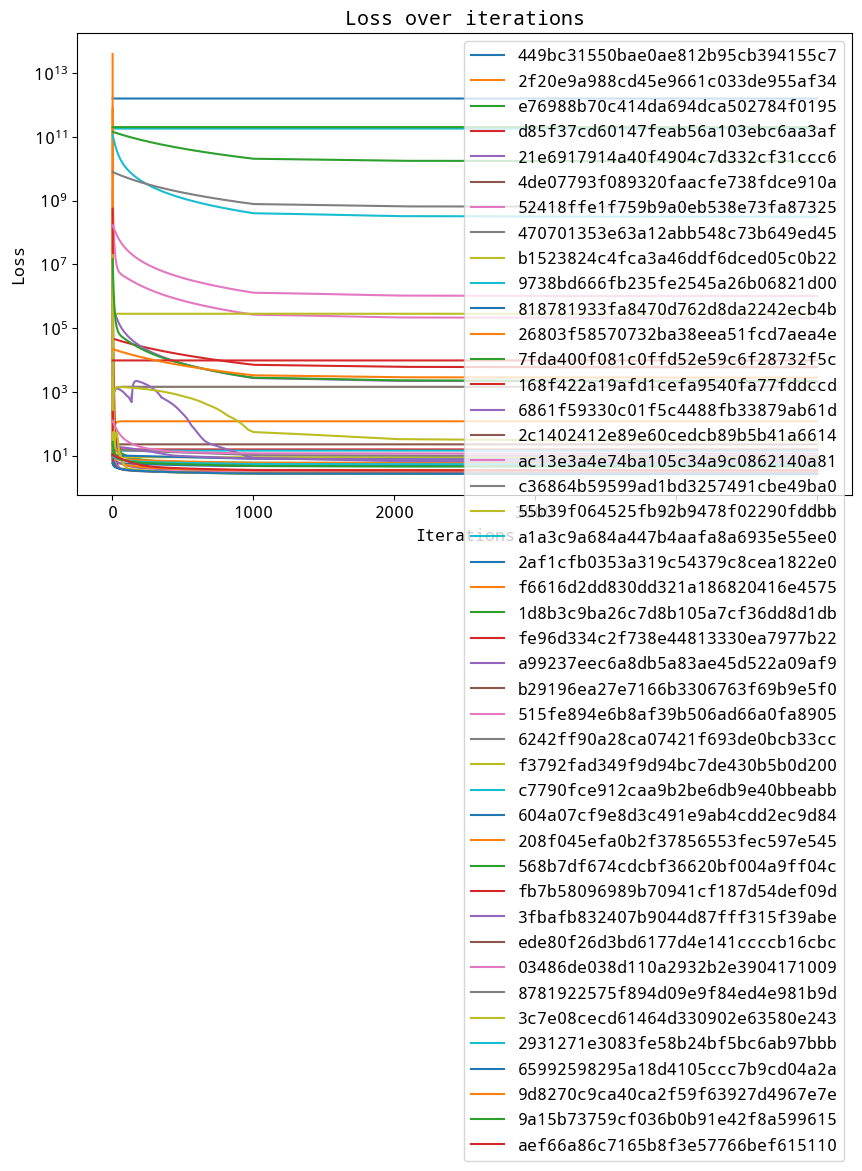

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for model in losses.model_run_id.unique():
    losses[losses.model_run_id == model].plot.line(x="niter", y="loss", ax=ax, label=model)

ax.set_yscale("log")
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss over iterations")
ax.legend()


In [18]:
paths_diffs = list(Path("../test_models/std_diffs/").glob("*.parquet"))
diffs = pd.concat([pd.read_parquet(p) for p in paths_diffs])

In [19]:
diffs.model_run_id.unique()

array(['2f20e9a988cd45e9661c033de955af34',
       '3c7e08cecd61464d330902e63580e243',
       '6861f59330c01f5c4488fb33879ab61d',
       'a99237eec6a8db5a83ae45d522a09af9',
       '515fe894e6b8af39b506ad66a0fa8905',
       'f3792fad349f9d94bc7de430b5b0d200',
       'e76988b70c414da694dca502784f0195',
       '2931271e3083fe58b24bf5bc6ab97bbb',
       'c7790fce912caa9b2be6db9e40bbeabb',
       'ede80f26d3bd6177d4e141ccccb16cbc',
       '65992598295a18d4105ccc7b9cd04a2a',
       '4de07793f089320faacfe738fdce910a',
       '3fbafb832407b9044d87fff315f39abe',
       '2c1402412e89e60cedcb89b5b41a6614',
       'fe96d334c2f738e44813330ea7977b22',
       '470701353e63a12abb548c73b649ed45',
       'd85f37cd60147feab56a103ebc6aa3af',
       '1d8b3c9ba26c7d8b105a7cf36dd8d1db',
       '168f422a19afd1cefa9540fa77fddccd',
       '2af1cfb0353a319c54379c8cea1822e0',
       'f6616d2dd830dd321a186820416e4575',
       'aef66a86c7165b8f3e57766bef615110',
       '818781933fa8470d762d8da2242ecb4b',
       '7fd

/home/topcat/projects/extract/src/prescribed/plot.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_diffs["family_covar"] = [


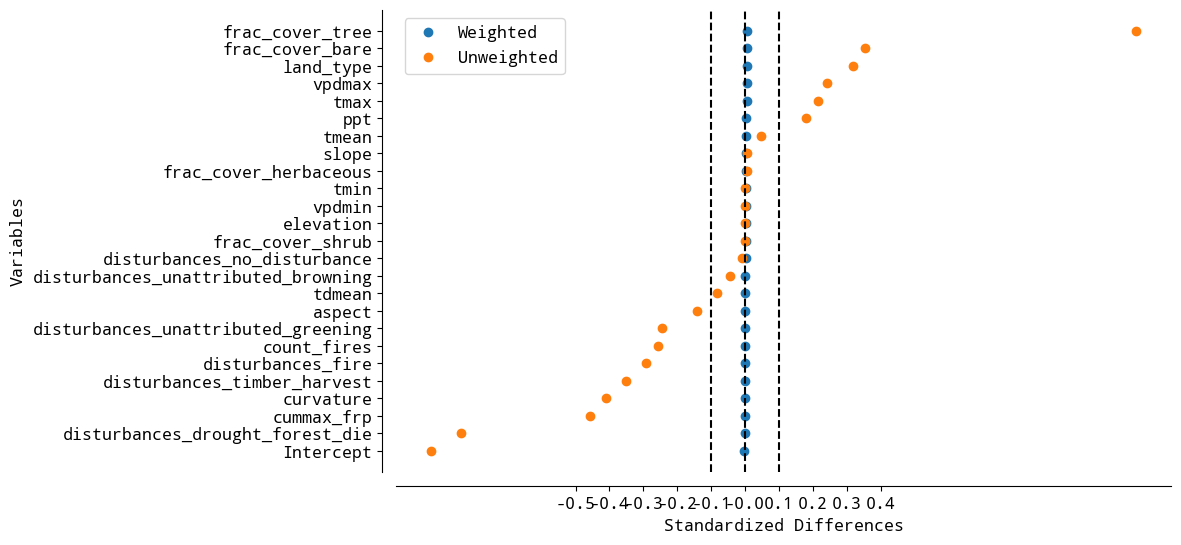

In [24]:
from prescribed.plot import plot_std_diffs_focal_year
plot_std_diffs_focal_year(std_diffs=diffs[diffs.model_run_id == "3c7e08cecd61464d330902e63580e243"], focal_year=2008)